In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor


In [31]:
# Create a function to preprocess data

def precprocess_data(file, n_future=5):
    df = pd.read_csv(file)
    df["Date/Time"] = pd.to_datetime(df["Date/Time"])
    df.sort_values(by="Date/Time").reset_index(drop=True)
    
    # Add price gap
    df["Price Movement"] = df["Close"].shift(-n_future) - df["Close"]

    # Get seperate date
    df = df.dropna()
    df["Hour"] = df["Date/Time"].dt.hour
    df["Minute"] = df["Date/Time"].dt.minute
    df['Day'] = df["Date/Time"].dt.dayofweek

    # Get stats
    df["Average_stock_rate_3"] = df["Close"].rolling(window=3).mean()
    df["Average_stock_rate_5"] = df["Close"].rolling(window=5).mean()
    df["Rate_of_change_stock"] = df["Close"].diff()
    df["Rate_of_change_volume"] = df["Volume"].diff()

    # Drop rows with NaN after comparing values
    df = df.dropna()
    df["Company"] = df["Ticker"]
    df.drop("Ticker", axis=1, inplace=True)

    return df



In [43]:
fpt_df = precprocess_data("FPT.csv")
msn_df = precprocess_data("MSN.csv")
pnj_df = precprocess_data("PNJ.csv")
vic_df = precprocess_data("VIC.csv")

df = pd.concat([fpt_df, msn_df, pnj_df, vic_df], ignore_index=True)



In [92]:
# Select feature for training
company_id = {
    "FPT": 1,
    "MSN": 2,
    "PNJ": 3,
    "VIC": 4}
df["Company_ID"] = df["Company"].map(company_id)
features = ["Company_ID","Minute", "Hour", "Day", "Close", "Volume", "Average_stock_rate_3", "Average_stock_rate_5", "Rate_of_change_stock", "Rate_of_change_volume" ]

X = df[features]
y = df["Price Movement"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [93]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [86]:
# Use Linear Regression for the base model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_lr_pred = lr_model.predict(X_test_scaled)

# Model evaluation
mae_lr = mean_absolute_error(y_test, y_lr_pred)
mse_lr = np.sqrt(mean_squared_error(y_test, y_lr_pred))

print("***** Linear Regression Results *****")
print(f"Mean Absolute Error: {mae_lr:.2f}")
print(f"Root Mean Squared Error: {mse_lr:.2f}")

***** Linear Regression Results *****
Mean Absolute Error: 0.22
Root Mean Squared Error: 0.40


In [105]:
# Use Random Forest Regressor for better prediction
# Train and predict data according to the company
res = {}
print("***** Random Forest Regressor Results *****")
for company in df["Company"].unique():
    company_df = df[df["Company"] == company]
    X_company = company_df[features]
    y_company = company_df["Price Movement"]
    X_train, X_test, y_train, y_test = train_test_split(X_company, y_company, test_size=0.2, random_state=42)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_rf_pred = rf_model.predict(X_test)

    # Model evaluation
    mae_rf = mean_absolute_error(y_test, y_rf_pred)
    mse_rf = np.sqrt(mean_squared_error(y_test, y_rf_pred))

    res[company] = [mae_rf, mse_rf]
    print(f"Mean Absolute Error for {company}: {mae_rf:.2f}")
    print(f"Root Mean Squared Error for {company}: {mse_rf:.2f}")




***** Random Forest Regressor Results *****
Mean Absolute Error for FPT: 0.07
Root Mean Squared Error for FPT: 0.12
Mean Absolute Error for MSN: 0.19
Root Mean Squared Error for MSN: 0.33
Mean Absolute Error for PNJ: 0.39
Root Mean Squared Error for PNJ: 0.59
Mean Absolute Error for VIC: 0.18
Root Mean Squared Error for VIC: 0.32


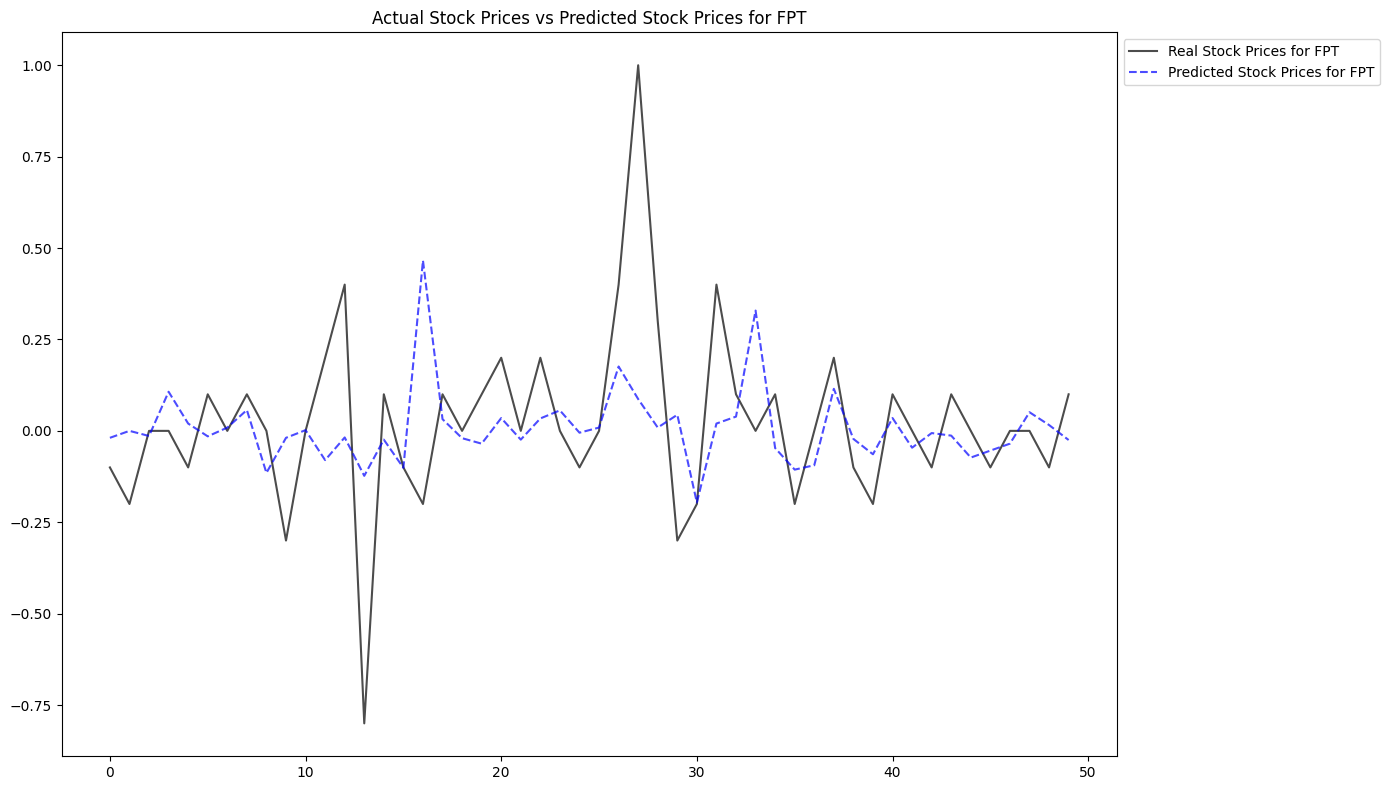

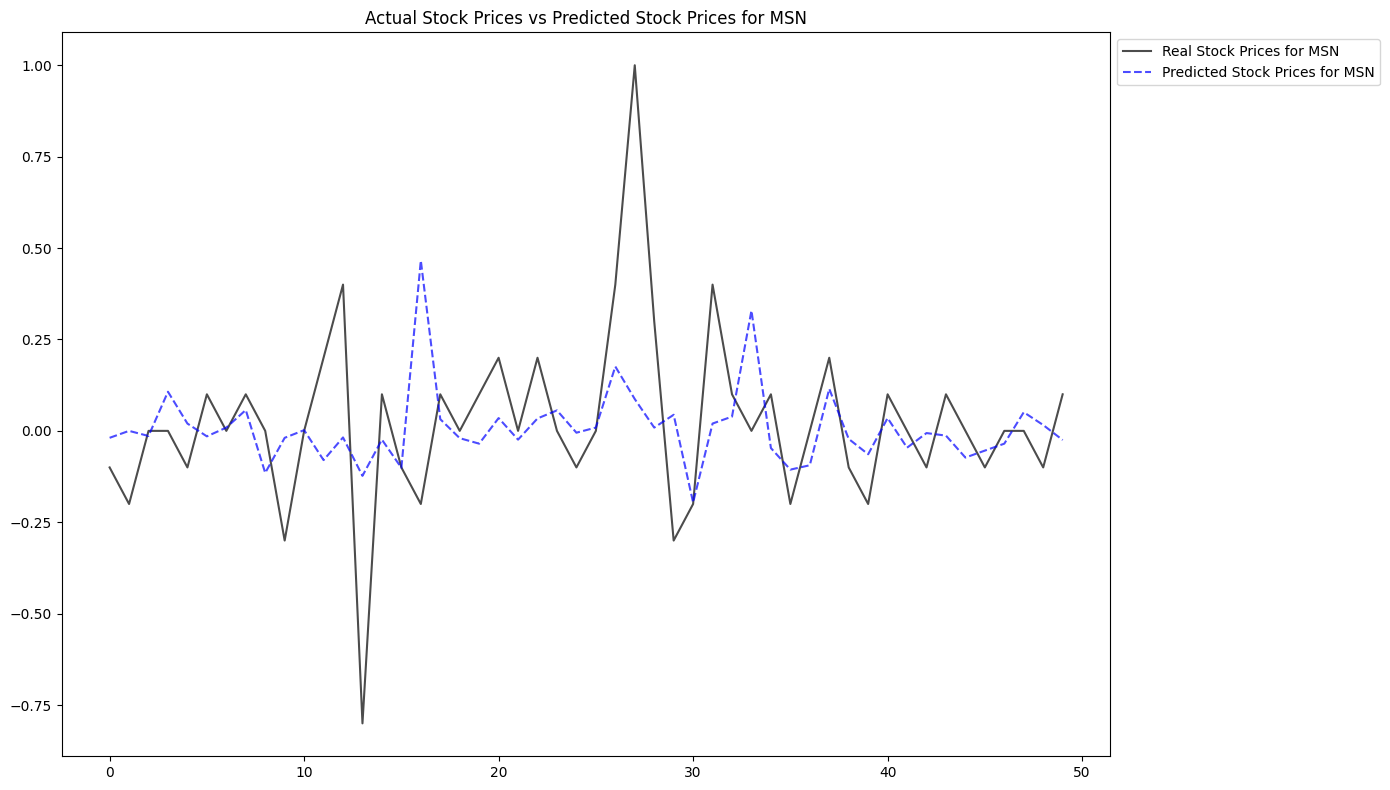

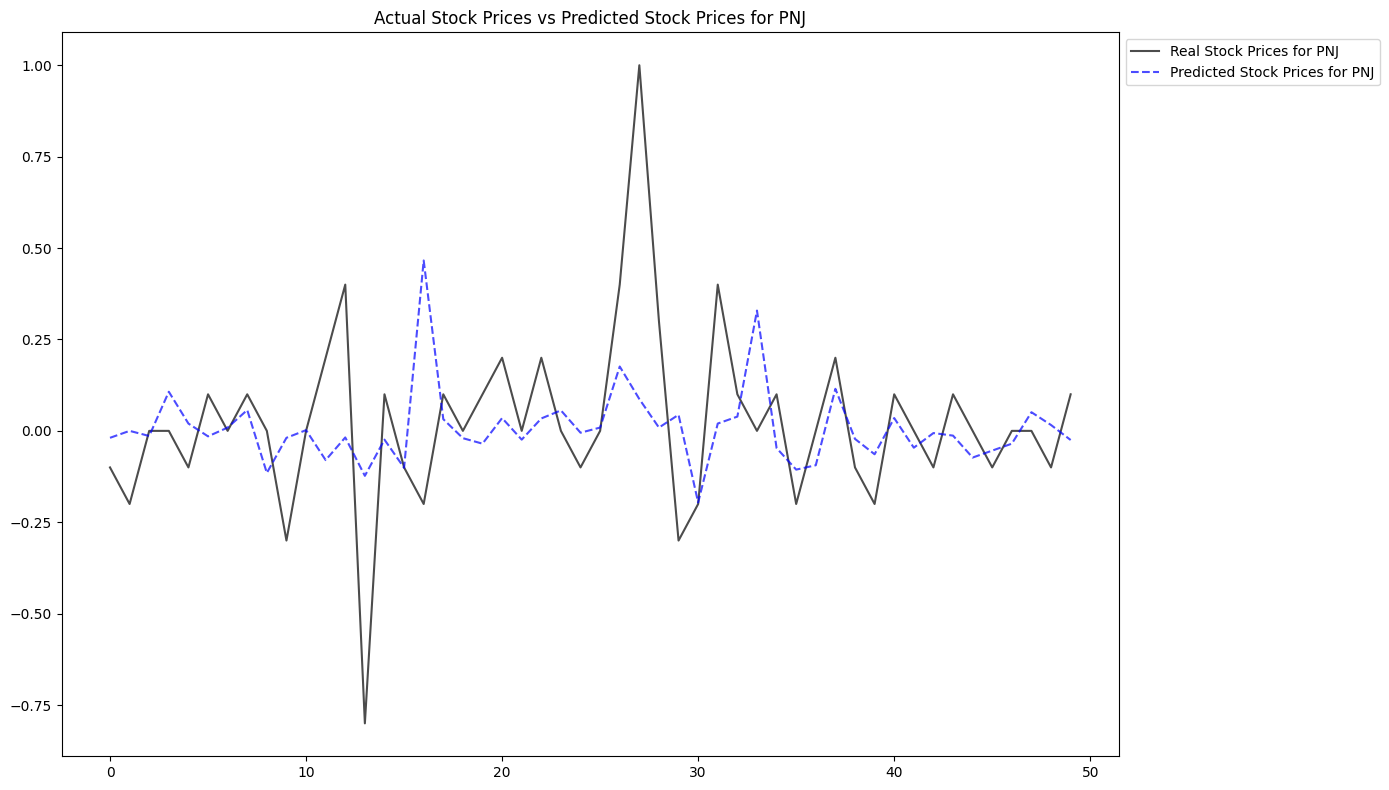

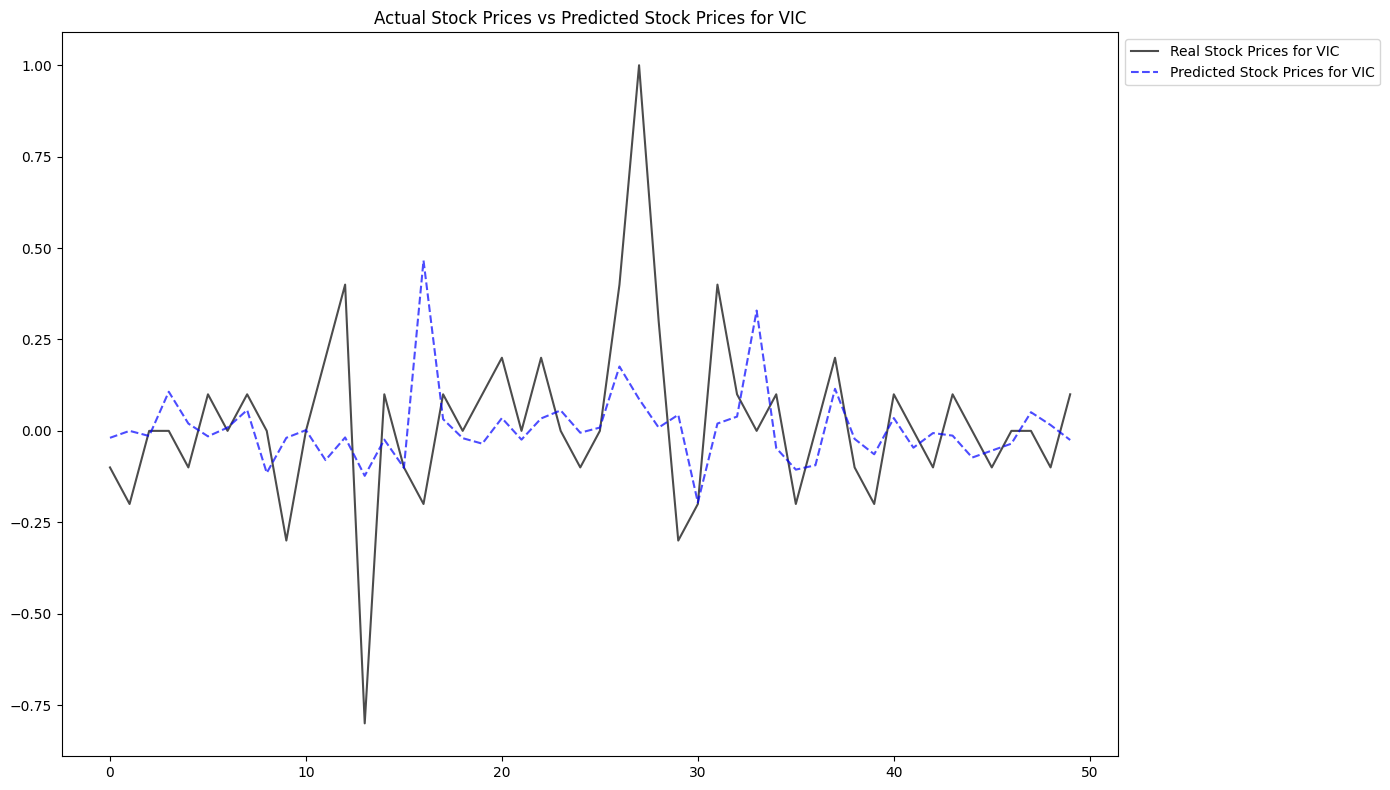

In [106]:
for company in df["Company"].unique():
    # Plot the model for each companies
    plt.figure(figsize=(14,8))
    plt.plot(y_test.values[:50], label=f"Real Stock Prices for {company}", alpha=0.7, color="black")
    plt.plot(y_rf_pred[:50], label=f"Predicted Stock Prices for {company}", alpha=0.7, color="blue", linestyle="--")
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.title(f"Actual Stock Prices vs Predicted Stock Prices for {company}")
    plt.tight_layout()
    plt.show()

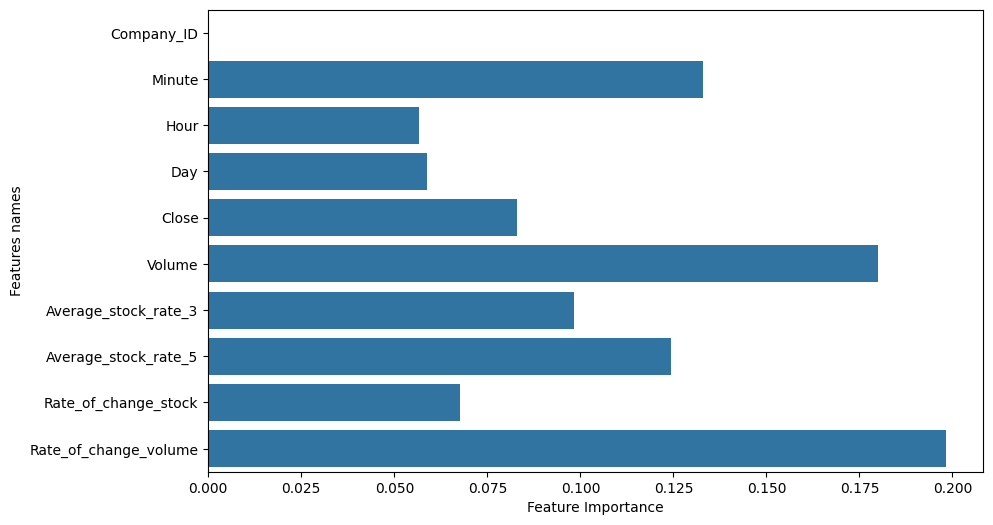

In [100]:
# Feature importances plot
importance = rf_model.feature_importances_
plt.figure(figsize=(10,6))
sns.barplot(x=importance, y=features)
plt.ylabel("Features names")
plt.xlabel("Feature Importance")
plt.show()

In [108]:
df.to_csv("Processed_Data_from_All_Companiess")